In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import seaborn as sb
from sklearn.decomposition import PCA
from matplotlib.ticker import AutoMinorLocator
from sklearn.preprocessing import StandardScaler
import warnings
import pickle
import pandas_datareader as pdr
import pandas_datareader.data as web
import getFamaFrenchFactors as gff

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler, StandardScaler
mm_scaler = MinMaxScaler()
ss_scaler = StandardScaler()

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore", category=FutureWarning, module="yfinance")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas_datareader.data")

# Stocks

## Fama-French

In [2]:
column_trans = {'Clths': 'Apparel', 'Banks': 'Banks', 'RlEst': 'Real Estate', 'Food ': 'Food', 'Oil  ': 'Energy', 'Hlth ': 'Health',
                'Meals': 'Restaurants, Hotels, Resorts', 'Hshld': 'Household', 'Fun  ': 'Leisure', 'PerSv': 'Personal Services', 'BusSv': 'Business Services',
               'Trans': 'Transportation', 'Telcm': 'Communication', 'Softw': 'Computer Software', 'Beer ': 'Beer, Ale, Malt',
               'Toys ': 'Toys', 'Soda ': 'Candy & Soda', 'Aero ': 'Aircraft', 'Gold ': 'Precious Metals',
               'Cnsmr':'Consumer', 'Manuf':'Manufacturing', 'HiTec':'Tech', 'Durbl':'Durables','Enrgy':'Energy','Utils':'Utilities'}

In [3]:
web.DataReader('F-F_Momentum_Factor','famafrench', '1920')[0]

,Mom
Date,
1927-01,0.36
1927-02,-2.14
1927-03,3.61
1927-04,4.30
1927-05,3.00
...,...
2024-06,0.90
2024-07,-2.42
2024-08,4.79


In [4]:
dt_ff = web.DataReader('10_Industry_Portfolios','famafrench', '1920') #Monthly
dt_ff = dt_ff[1] #0 Average Value Weighted Returns  1 Average Equal Weighted Returns
stock_dict = dt_ff.rename(columns = column_trans) # / 100
stock_dict.tail()

,NoDur,Durables,Manufacturing,Energy,Tech,Communication,Shops,Health,Utilities,Other
Date,,,,,,,,,,
2024-06,-4.33,-7.26,-5.36,-5.42,-0.23,1.89,-3.14,-6.88,-3.09,-0.99
2024-07,4.81,4.06,6.32,4.35,4.53,13.58,3.85,8.34,8.93,9.37
2024-08,-1.51,-4.01,-2.59,-6.36,-2.58,-3.85,-2.63,-4.12,0.30,-1.89
2024-09,1.16,-2.72,4.06,-0.56,0.51,2.74,3.20,-2.67,3.65,-0.19
2024-10,-2.17,-4.30,-1.96,-1.65,0.70,1.01,-5.14,1.34,-0.08,0.89


### FF-3

In [5]:
ff_3 = gff.famaFrench3Factor(frequency='m').set_index('date_ff_factors').resample('M').last()
ff_3.index = ff_3.index.to_period('M')
mkt = ff_3['Mkt-RF'].rename('MKT-RF')
smb = ff_3['SMB'].rename('SMB')
hml = ff_3['HML'].rename('HML')
stock_dict=stock_dict.sub(ff_3.RF, axis=0)
ff_3.tail()

,Mkt-RF,SMB,HML,RF
date_ff_factors,,,,
2024-06,0.0277,-0.0306,-0.0331,0.0041
2024-07,0.0124,0.0680,0.0574,0.0045
2024-08,0.0161,-0.0355,-0.0113,0.0048
2024-09,0.0174,-0.0017,-0.0259,0.0040
2024-10,-0.0097,-0.0100,0.0089,0.0039


In [6]:
c4f = gff.carhart4Factor(frequency='m').set_index('date_ff_factors').resample('M').last()
c4f.index = c4f.index.to_period('M')
ff_5 = gff.famaFrench5Factor(frequency='m').set_index('date_ff_factors').resample('M').last()
ff_5.index = ff_5.index.to_period('M')

# Macroeconomic variables

In [7]:
def get_fred_prices(assets, print_=True):
    df_temp = pd.DataFrame()
    beginning_date = '1900-01-01'
    for key, value in assets.items():
        print('Getting {} with symbol {}'.format(key, value)) if print_ == True else 0
        try:
            df_temp[f'{key}'] = pdr.DataReader(f'{value}','fred', beginning_date)
        except:
            print('Error getting {}'.format(value))
    return(df_temp)

## CPI

In [8]:
CPI = get_fred_prices({'CPI':'CPIAUCSL'})
CPI.index = CPI.index.to_period('M')
CPI = CPI.rolling(12).mean()

Getting CPI with symbol CPIAUCSL


## Unemployment rate

In [9]:
UNRATE = get_fred_prices({'Unemployment':'UNRATE'})
UNRATE.index = UNRATE.index.to_period('M')
UNRATE.tail()

Getting Unemployment with symbol UNRATE


,Unemployment
DATE,
2024-07,4.3
2024-08,4.2
2024-09,4.1
2024-10,4.1
2024-11,4.2


In [10]:
UNRATE = get_fred_prices({'Unemployment':'UNRATE'})
UNRATE.index = UNRATE.index.to_period('M')
CIVPART = get_fred_prices({'CIVPART':'CIVPART'})
CIVPART.index = CIVPART.index.to_period('M')
ICSA = get_fred_prices({'ICSA':'ICSA'}).resample('M').mean()
ICSA.index = ICSA.index.to_period('M')
UNRATE = pd.concat((UNRATE,CIVPART, ICSA), axis=1).dropna()
from sklearn.preprocessing import MinMaxScaler, StandardScaler
mm_scaler = MinMaxScaler()
UNRATE = pd.DataFrame(mm_scaler.fit_transform(UNRATE), columns=UNRATE.columns, index=UNRATE.index)#.rolling(3).std()
#UNRATE = UNRATE.rolling(9).std().sum(axis=1).to_frame().rename({0:'CLMI'},axis=1)
UNRATE = (UNRATE.div(UNRATE.drop('ICSA',axis=1).sum(axis=1), axis=0)['ICSA'].to_frame('CLMI')).rolling(2).mean()
#UNRATE = UNRATE.sum(1).to_frame('CLMI').rolling(3).std()

Getting Unemployment with symbol UNRATE
Getting CIVPART with symbol CIVPART
Getting ICSA with symbol ICSA


## Money supply

In [11]:
M2 = get_fred_prices({'M2': 'M2SL'}, print_=False)
M2.index = M2.index.to_period('M')
M2.tail()

,M2
DATE,
2024-06,21020.1
2024-07,21039.4
2024-08,21141.3
2024-09,21222.7
2024-10,21311.2


## Oil

In [12]:
oil = get_fred_prices({'WTI': 'DCOILWTICO'}, print_=False).resample('M').last()
oil.index = oil.index.to_period('M')
oil.tail()

,WTI
DATE,
2024-08,74.52
2024-09,68.75
2024-10,69.58
2024-11,68.26
2024-12,68.65


## Credit spread

In [13]:
baa_spread = get_fred_prices({'BAA10Y': 'BAA10Y'}, print_=False).resample('M').last()
baa_spread.index = baa_spread.index.to_period('M')
_10Y3MS = get_fred_prices({'10Y3MS': 'T10Y3M'}, print_=False).resample('M').last()
_10Y3MS.index = _10Y3MS.index.to_period('M')

In [14]:
CCM = pd.concat((baa_spread,_10Y3MS), axis=1).dropna().rolling(2).std().sum(axis=1).to_frame('CCM')
CCM.head()

,CCM
DATE,
1986-01,0.000000
1986-02,0.848528
1986-03,0.325269
1986-04,0.268701
1986-05,0.622254


## Michigan

In [15]:
michigan = pd.read_csv('csv/michigan.csv',header=1)
michigan['Date'] = pd.to_datetime(michigan.Year.astype(str) + '-' + michigan.Month.astype(str))
michigan = michigan.set_index(['Date']).Index
michigan.index = michigan.index.to_period('M')
michigan.name='MCSI'

In [16]:
michigan = get_fred_prices({'MCSI': 'UMCSENT'}, print_=False).resample('M').last().rolling(3).mean()
michigan.index = michigan.index.to_period('M')
michigan.head()

,MCSI
DATE,
1952-11,NaN
1952-12,NaN
1953-01,NaN
1953-02,NaN
1953-03,NaN


## Volatility

In [17]:
vix = get_fred_prices({'VIX': 'VIXCLS'}, print_=False)

sp500_vol = yf.download('^SPX')['Adj Close'].pct_change().rolling(22).std() * np.sqrt(252) * 100 #get_fred_prices({'mkt':'SP500'}).pct_change().rolling(22).std() * np.sqrt(252) * 100

vix = vix.sub(sp500_vol,0).resample('M').mean()
vix.index = vix.index.to_period('M')
vix.head()

[*********************100%***********************]  1 of 1 completed


,VIX
1927-12,NaN
1928-01,NaN
1928-02,NaN
1928-03,NaN
1928-04,NaN


## Industrial production & Capacity utilization (Capacity & Production Efficiency Measure)

In [18]:
capacity = get_fred_prices({'Capacity': 'TCU'}, print_=False).resample('M').last()
capacity.index = capacity.index.to_period('M')

ip = get_fred_prices({'Prod': 'INDPRO'}, print_=False).resample('M').last()
ip.index = ip.index.to_period('M')
cpem = pd.concat((capacity,ip), axis=1).dropna()#.rolling(2).std().sum(axis=1).to_frame('CCM')
cpem = (cpem['Capacity'] * (cpem['Prod'].pct_change())).to_frame('CPEM')
cpem.head()

,CPEM
DATE,
1967-01,NaN
1967-02,-0.997743
1967-03,-0.490714
1967-04,0.825243
1967-05,-0.753313


## Baltic

In [19]:
baltic = pd.read_csv('csv/baltic.csv',header=0, thousands='.', decimal=',')[['Date','Dernier']]
baltic['Date'] = pd.to_datetime(baltic.Date, dayfirst=True)
baltic = baltic.set_index(['Date'])
baltic = baltic.resample('M').mean().interpolate().diff().rename(columns={'Dernier':'BDI'})
baltic.index = baltic.index.to_period('M')
baltic.head()

,BDI
Date,
1985-02,NaN
1985-03,32.5
1985-04,46.5
1985-05,-131.5
1985-06,-59.0


## Weighted Trade Balance

In [20]:
tb = get_fred_prices({'TB': 'BOPGSTB'}, print_=False).resample('M').last()
tb.index = tb.index.to_period('M')
tb = pd.read_excel('csv/tb.xlsx', header=0).set_index('DATE')
tb.index = tb.index.to_period('M')

dxy = yf.download('DX-Y.NYB')['Adj Close']
dxy = dxy.resample('M').last()#.pct_change().rolling(6).mean()#.pct_change()
dxy.index = dxy.index.to_period('M')
dxy = dxy.to_frame('dxy')

GDP = get_fred_prices({'R_GDP':'GDPC1'})
GDP = GDP.resample('M').last()
GDP.index = GDP.index.to_period('M')
GDP = GDP.interpolate()

WTB = pd.concat((tb,dxy, baltic,GDP.rolling(12).mean()),1).sort_index().ffill().dropna()
WTB = ( WTB['dxy'] *  WTB['TB'] / WTB['R_GDP'] ).to_frame('WTB').diff()#.rolling(12).mean()
WTB.head()

[*********************100%***********************]  1 of 1 completed
Getting R_GDP with symbol GDPC1


/var/folders/k8/nm1rvlt97lgdk7xbhcdy3h5r0000gn/T/ipykernel_30900/3040631679.py:16: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  WTB = pd.concat((tb,dxy, baltic,GDP.rolling(12).mean()),1).sort_index().ffill().dropna()


,WTB
1989-12,NaN
1990-01,-27.249883
1990-02,22.056320
1990-03,42.309374
1990-04,-43.305283


## Housing to price ratio

In [21]:
hp = get_fred_prices({'HP': 'USSTHPI'}, print_=False).resample('M').last().interpolate()
hp.index = hp.index.to_period('M')

houst = get_fred_prices({'HOUST': 'houst'}, print_=False).resample('M').last()
houst.index = houst.index.to_period('M')

hpr = pd.concat((hp,houst),1).dropna()
hpr = ( hpr['HOUST'] / hpr['HP'] ).to_frame('HPR')

/var/folders/k8/nm1rvlt97lgdk7xbhcdy3h5r0000gn/T/ipykernel_30900/677484211.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  hpr = pd.concat((hp,houst),1).dropna()


## PPI

In [22]:
ppi = get_fred_prices({'PPI': 'PPIACO'}, print_=False).resample('M').last()
ppi.index = ppi.index.to_period('M')
ppi.head()

,PPI
DATE,
1913-01,12.1
1913-02,12.0
1913-03,12.0
1913-04,12.0
1913-05,11.9


## Debt to GDP

In [23]:
debt = get_fred_prices({'D2GDP': 'GFDEGDQ188S'}, print_=False).resample('M').last().interpolate()
debt.index = debt.index.to_period('M')
debt.head()

,D2GDP
DATE,
1966-01,40.339990
1966-02,39.982537
1966-03,39.625083
1966-04,39.267630
1966-05,39.385390


In [24]:
debt = debt.fillna(debt.rolling(12,min_periods=1).mean())

## Market returns

In [25]:
mkt_returns = yf.download(['^FTSE','^FCHI','^GDAXI','^N225',])['Adj Close'].dropna().resample('M').last().rolling(6, min_periods=1).mean()
mkt_returns.index = mkt_returns.index.to_period('M')
mkt_returns.head()

[*********************100%***********************]  4 of 4 completed


,^FCHI,^FTSE,^GDAXI,^N225
Date,,,,
1990-03,1972.000000,2247.899902,1966.750000,29980.449219
1990-04,2019.000000,2177.250000,1892.275024,29782.625000
1990-05,2048.333333,2233.200033,1873.746663,30898.683594
1990-06,2045.000000,2268.550049,1876.477509,31159.072754
1990-07,2029.000000,2280.080029,1885.766016,31134.390234


## Coincident index

In [26]:
cei = get_fred_prices({'CEI': 'USPHCI'}, print_=False).resample('M').last().pct_change().rolling(6).mean()
cei.index = cei.index.to_period('M')
cei.tail()

,CEI
DATE,
2024-06,0.002234
2024-07,0.002067
2024-08,0.002156
2024-09,0.001919
2024-10,0.001823


## Retail sales

In [27]:
rs = get_fred_prices({'RS': 'RSXFS'}, print_=False).resample('M').last().pct_change().rolling(6).mean()
rs.index = rs.index.to_period('M')
rs

,RS
DATE,
1992-01,NaN
1992-02,NaN
1992-03,NaN
1992-04,NaN
1992-05,NaN
...,...
2024-06,-0.000184
2024-07,0.003867
2024-08,0.002152


## Policy Uncertainty

In [28]:
pu = pd.read_excel('csv/Policy_Uncertainty.xlsx')
pu['Date'] = pd.to_datetime(pu['Year'].astype(str) + '-' + pu['Month'].astype('str'))
pu.set_index ('Date', inplace=True)
pu.index = pu.index.to_period('M')
epu = pu['News_Based_Policy_Uncert_Index'].to_frame('EPU').rolling(2).mean()
epu.tail()

,EPU
Date,
2024-06,133.892972
2024-07,144.557612
2024-08,141.651612
2024-09,134.444360
2024-10,131.969689


## Import export balance

In [29]:
ie = pd.read_excel('csv/import_export.xlsx')
month_map_i = {'IJAN': 1, 'IFEB': 2, 'IMAR': 3, 'IAPR': 4, 'IMAY': 5, 'IJUN': 6, 'IJUL': 7, 'IAUG': 8, 'ISEP': 9, 'IOCT': 10, 'INOV': 11, 'IDEC': 12}
month_map_e = {'EJAN': 1, 'EFEB': 2, 'EMAR': 3, 'EAPR': 4, 'EMAY': 5, 'EJUN': 6, 'EJUL': 7, 'EAUG': 8, 'ESEP': 9, 'EOCT': 10, 'ENOV': 11, 'EDEC': 12}
def import_export(file, ct, i_e):
    i_e = month_map_i if i_e == 'i' else month_map_e
    ie_dt = file[file['CTYNAME']==ct]
    dt = ie_dt.melt(id_vars='year', value_vars = i_e.keys(), var_name='month', value_name='d')
    dt.month = dt['month'].map(i_e)
    dt['Date'] = pd.to_datetime(dt['year'].astype(str) + '-' + dt['month'].astype('str'))
    dt = dt.set_index('Date')
    dt.index = dt.index.to_period('M')
    return dt.d.sort_index()

In [30]:
ct = 'China'
#import
ie_i = import_export(ie,ct,'i')
#export
ie_e = import_export(ie,ct,'e')
ch_bal = (ie_e - ie_i).to_frame('CHB')
ct = 'European Union'
#import
ie_i = import_export(ie,ct,'i')
#export
ie_e = import_export(ie,ct,'e')
ue_bal = (ie_e - ie_i).to_frame('UEB')

## Emission

In [31]:
emission = pd.read_excel('csv/carbon_emission.xlsx').set_index('Month')
emission = emission.iloc[:,-1:]
emission.index = emission.index.to_period('M')
emission = emission.rename(columns={emission.columns[0]:'CO2'})
emission.tail()

,CO2
Month,
2024-03,383.807
2024-04,358.837
2024-05,374.876
2024-06,381.058
2024-07,421.422


## Electricity

In [32]:
el = pd.read_excel('csv/electricity.xlsx').set_index('Month')
el = el.iloc[:,-1:]
el.index = el.index.to_period('M')
el = el.rename(columns={el.columns[0]:'EG'})
el.tail()

,EG
Month,
2024-03,306.474
2024-04,294.715
2024-05,323.098
2024-06,363.177
2024-07,406.419


## Temperature

In [33]:
temp = pd.read_csv('csv/temp.csv')
temp = temp.melt(id_vars='Year', value_vars=temp.columns[3:], value_name='Temp')
temp['Date'] = pd.to_datetime( temp['variable'].astype('str') + '-' + temp['Year'].astype('str') )
temp.set_index('Date', inplace=True)
temp.index = temp.index.to_period('M')
temp = temp['Temp'].to_frame('TMP').sort_index()

## ——————————Descriptive statistics——————————

#### Describe table

In [33]:
chars = (0.01*stock_dict['1990':]).describe().T.sort_index().round({'count':0,'mean':3,'std':3}).rename(columns={'count':'N','mean':'Mean','std':'Std.Dev.'}).iloc[:,:3]
chars['Mean'] = chars['Mean'] * 12
chars['Std.Dev.'] = chars['Std.Dev.'] * np.sqrt(12)
print(chars.round(4).to_latex(escape=False, bold_rows=True))

\begin{tabular}{lrrr}
\toprule
{} &      N &   Mean &  Std.Dev. \\
\midrule
\textbf{Communication} &  417.0 &  0.108 &    0.2806 \\
\textbf{Durables     } &  417.0 &  0.096 &    0.2598 \\
\textbf{Energy       } &  417.0 &  0.120 &    0.3464 \\
\textbf{Health       } &  417.0 &  0.144 &    0.2737 \\
\textbf{Manufacturing} &  417.0 &  0.132 &    0.2148 \\
\textbf{NoDur        } &  417.0 &  0.096 &    0.1767 \\
\textbf{Other        } &  417.0 &  0.120 &    0.1732 \\
\textbf{Shops        } &  417.0 &  0.120 &    0.2217 \\
\textbf{Tech         } &  417.0 &  0.168 &    0.2875 \\
\textbf{Utilities    } &  417.0 &  0.120 &    0.1247 \\
\bottomrule
\end{tabular}



/var/folders/k8/nm1rvlt97lgdk7xbhcdy3h5r0000gn/T/ipykernel_36633/1288740018.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(chars.round(4).to_latex(escape=False, bold_rows=True))


##### Autocorrelation table

In [34]:
autocorr_df = pd.DataFrame()
for n in range(1,6):
    autocorr_df[('\rho_'+str(n))] = stock_dict.apply(lambda x: x.autocorr(lag=n)) #stock_dict
print(autocorr_df.sort_index().round(4).to_latex(escape=False, bold_rows=True))

\begin{tabular}{lrrrrr}
\toprule
{} &  \rho_1 &  \rho_2 &  \rho_3 &  \rho_4 &  \rho_5 \\
\midrule
\textbf{Communication} &  0.1758 &  0.0000 &  0.0088 &  0.0013 &  0.0793 \\
\textbf{Durables     } &  0.2140 &  0.0237 & -0.0653 & -0.0699 & -0.0099 \\
\textbf{Energy       } &  0.0886 &  0.0386 & -0.0223 &  0.0054 &  0.0047 \\
\textbf{Health       } &  0.1763 &  0.0065 & -0.0656 & -0.0053 &  0.0359 \\
\textbf{Manufacturing} &  0.1784 &  0.0191 & -0.0860 & -0.0453 &  0.0008 \\
\textbf{NoDur        } &  0.2174 &  0.0290 & -0.0569 & -0.0472 &  0.0135 \\
\textbf{Other        } &  0.2006 & -0.0034 & -0.0869 & -0.0421 &  0.0130 \\
\textbf{Shops        } &  0.2272 &  0.0396 & -0.0389 & -0.0628 & -0.0150 \\
\textbf{Tech         } &  0.1782 &  0.0017 & -0.0581 & -0.0485 & -0.0003 \\
\textbf{Utilities    } &  0.1023 & -0.0408 & -0.0989 &  0.0001 &  0.0237 \\
\bottomrule
\end{tabular}



/var/folders/k8/nm1rvlt97lgdk7xbhcdy3h5r0000gn/T/ipykernel_36633/1919139284.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(autocorr_df.sort_index().round(4).to_latex(escape=False, bold_rows=True))


In [36]:
log_diff_vars = np.log(pd.concat((CPI, M2, oil, UNRATE, ppi, debt, mkt_returns, CCM, emission, ), axis=1).dropna()).diff().dropna()
#diff_vars = vix
no_diff_vars = pd.concat((michigan, vix, mkt, cpem, WTB, hpr, baltic, cei, epu, ch_bal, temp, el), axis=1).dropna() #smb hml
combined_df = pd.concat((log_diff_vars, no_diff_vars), axis=1).dropna()

combined_df = pd.DataFrame(mm_scaler.fit_transform(combined_df), columns=combined_df.columns, index=combined_df.index).sort_index(axis='columns')

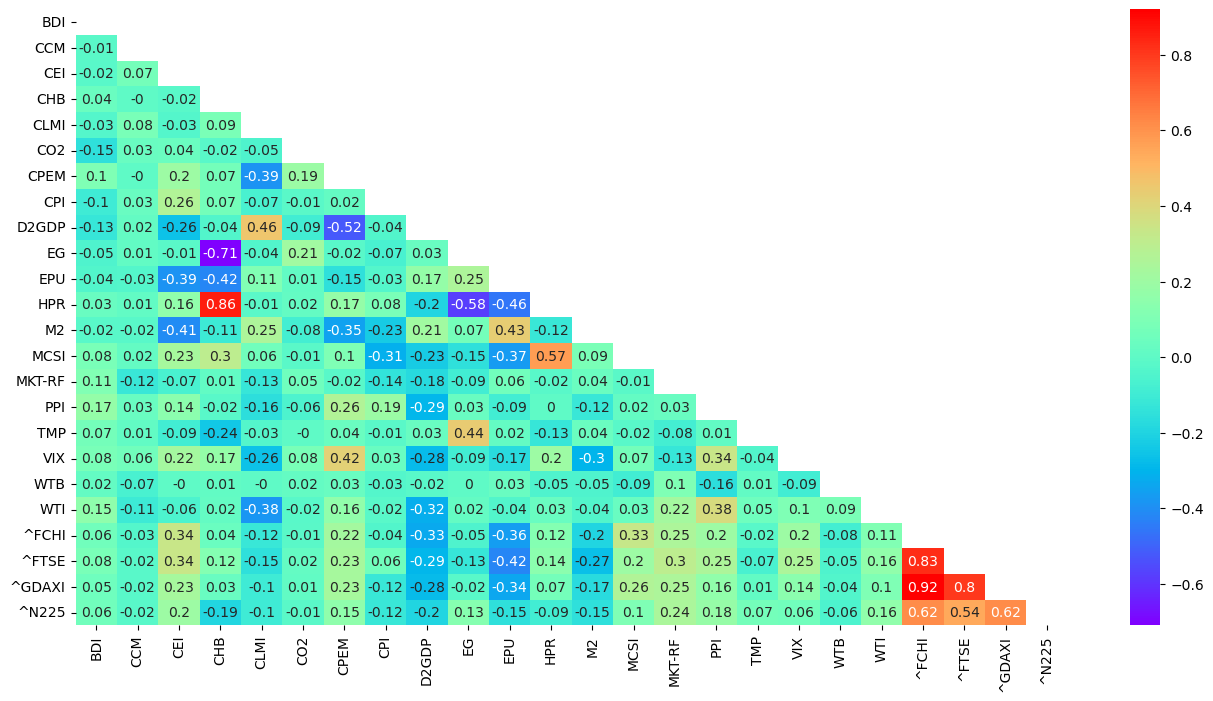

In [37]:
plt.figure(figsize=(16,8))
corr_df = pd.DataFrame(np.tril(combined_df.corr(), -1), index=combined_df.columns, columns=combined_df.columns).replace(0,np.nan).round(2)
hm = sb.heatmap(corr_df,cmap='rainbow', annot=True)
plt.xlabel('')
plt.ylabel('')
plt.grid('');

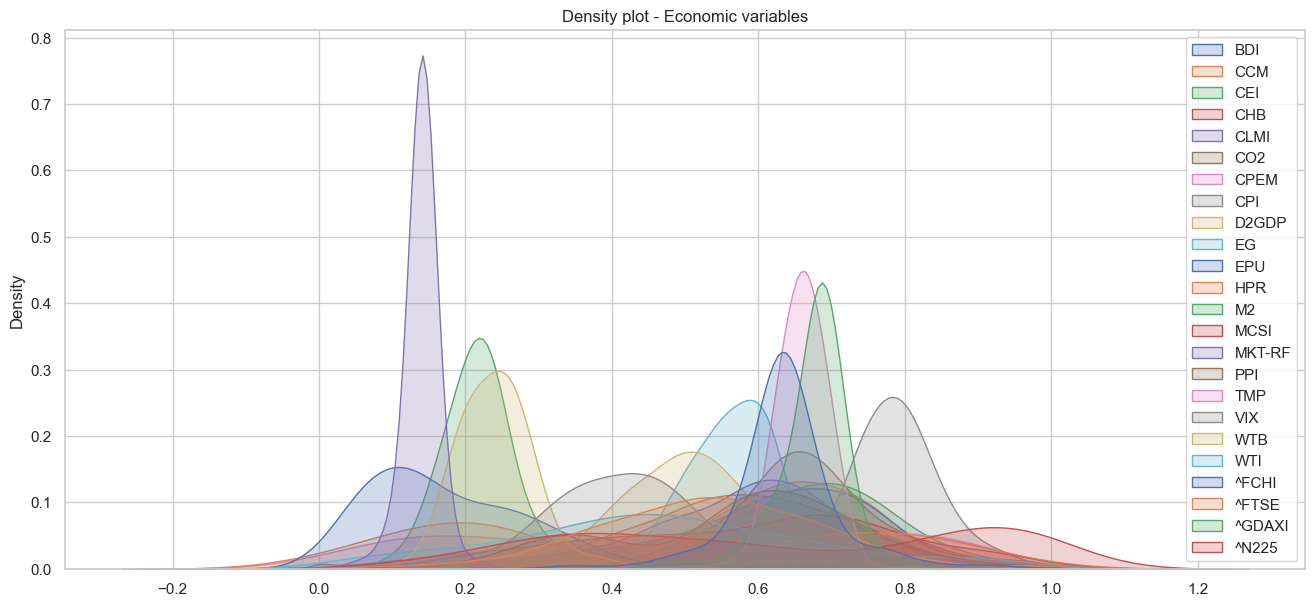

In [757]:
#periods = [:'']
sb.set(style="whitegrid")
#combined_df = combined_df.T
plt.figure(figsize=(16,7))
sb.kdeplot(combined_df, fill=True, multiple='layer', palette='deep')
    
plt.title('Density plot - Economic variables')
plt.ylabel('Density')
#plt.yscale('log')
plt.show()

## Pooled Regressions

In [34]:
def pooled_ols_recap(key, model, i, star=True):
    multi_df[key] = list(model.params.round(3)) + [f'{model.rsquared_adj:.2%}'] #tous les coeffs et R2 à la fin
    p_values = [0] * len(model.pvalues.values) #créer une ligne de p-value 0

    for idx, p in enumerate(model.pvalues.values): #iteration sur les p values
        if star:
            if p < 0.02:
                p_values[idx] = f'({model.pvalues.values[idx]:.2f})***'
            elif p < 0.06:
                p_values[idx] = f'({model.pvalues.values[idx]:.2f})**'
            elif p < 0.11:
                p_values[idx] = f'({model.pvalues.values[idx]:.2f})*'
            else: 
                p_values[idx] = f'({model.pvalues.values[idx]:.2f})' #tvalues pvalues
        else:
            p_values[idx] = f'{model.pvalues.values[idx]:.2f}'
    #pour below, je créer une ligne avec comme index le i du enumerate du code en bas, pour pas effacer everytime
    multi_df[' '*i] = p_values + ['']#[(model.pvalues.values < 0.05).sum()] #[''] #voir cmb sont inférieur à 0.05

def show_multi_df(multi_df):
    multi_df.index = (list(model.params.index.values) + ['Adj. R2'])
    multi_df = multi_df.T
    return multi_df.rename({'const':'Constant'}, axis='columns')

from statsmodels.regression.rolling import RollingOLS

def calculate_IVOL(returns, df, window):
    """
    Calculate idiosyncratic volatility
    """
    df_ = sm.add_constant(df.iloc[:,:-1])
    df_ = combined_df.join(returns) #return = last column
    model = RollingOLS(endog=df_.iloc[:,-1:], exog=df_.iloc[:,:-1], window=window)
    rolling_residuals = df_.iloc[:,-1:].sum(1) - (model.fit().params * df_.iloc[:,:-1]).sum(1)
    return rolling_residuals

In [35]:
#combined_df.to_excel('combined_df.xlsx')
#stock_dict.to_excel('stock_dict.xlsx')

In [36]:
scaler = StandardScaler()
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

In [37]:
log_diff_vars = np.log(pd.concat((CPI, M2, oil, UNRATE, ppi, debt, mkt_returns, CCM, emission, ), axis=1).dropna()).diff().dropna()
#diff_vars = vix
no_diff_vars = pd.concat((michigan, vix, mkt, cpem, WTB, hpr, baltic, cei, epu, ch_bal, temp, el), axis=1).dropna() #smb hml
combined_df = pd.concat((log_diff_vars, no_diff_vars), axis=1).dropna()
combined_df = pd.DataFrame(mm_scaler.fit_transform(combined_df), columns=combined_df.columns, index=combined_df.index)
#combined_df = pd.DataFrame(scaler.fit_transform(combined_df), columns=combined_df.columns, index=combined_df.index)

#FF
multi_df = pd.DataFrame()
list_r2 = []
for i, key in enumerate(sorted(stock_dict.keys())):

    stock = stock_dict[key]

    df = pd.concat([stock.rename('Stock').shift(-1), combined_df.join(stock.rename('LAG')) ], #ff_3, ff_5, c4f pca_df
                   axis=1).dropna()#[:'2024'] #combined_df.join(stock.rename('LAG'))
    #df['IVol'] = calculate_IVOL(stock, combined_df, 21).rolling(3).std()#.shift(1) # 23 2/4
    #df.dropna(inplace=True)
    #df = df.iloc[-275:]
    y = df.iloc[:,0:1]
    x = df.iloc[:,1:]
    model = sm.OLS(y, sm.add_constant(x)).fit()
    pooled_ols_recap(key, model, i, )
    list_r2.append(model.rsquared_adj)
multi_df = show_multi_df(multi_df)
print(f'Average R2: {(sum(list_r2)/len(list_r2)):.2%}')
multi_df = multi_df.iloc[:,:1].join(multi_df.iloc[:,1:-1].sort_index(axis='columns')).join(multi_df.iloc[:,-1])
multi_df

Average R2: 16.13%


,Constant,BDI,CCM,CEI,CHB,CLMI,CO2,CPEM,CPI,D2GDP,EG,EPU,HPR,LAG,M2,MCSI,MKT-RF,PPI,TMP,VIX,WTB,WTI,^FCHI,^FTSE,^GDAXI,^N225,Adj. R2
Communication,-0.08,9.577,1.358,12.272,3.147,16.369,4.266,-4.615,-16.677,-16.027,-4.12,11.11,0.979,0.011,1.602,-6.584,4.538,1.138,-0.245,2.11,-5.346,-12.357,2.651,8.903,-13.907,4.735,13.98%
,(0.99),(0.03)**,(0.57),(0.06)**,(0.44),(0.10)*,(0.08)*,(0.61),(0.00)***,(0.01)***,(0.16),(0.01)***,(0.80),(0.88),(0.81),(0.03)**,(0.28),(0.76),(0.87),(0.69),(0.13),(0.04)**,(0.71),(0.09)*,(0.04)**,(0.18),
Durables,3.452,8.226,1.321,1.593,1.14,36.631,2.588,2.177,-16.912,-23.022,-3.247,16.335,3.267,-0.025,2.298,-7.651,3.465,1.682,-1.244,-1.991,-7.913,-6.556,-2.566,11.146,-6.247,1.285,23.38%
,(0.72),(0.03)**,(0.54),(0.78),(0.75),(0.00)***,(0.23),(0.79),(0.00)***,(0.00)***,(0.21),(0.00)***,(0.34),(0.73),(0.70),(0.00)***,(0.36),(0.61),(0.36),(0.67),(0.01)***,(0.23),(0.68),(0.02)***,(0.30),(0.68),
Energy,-33.125,11.433,5.127,21.8,5.55,76.818,-2.154,20.329,-9.592,-25.492,4.106,10.961,2.904,0.058,12.034,-10.346,-4.99,2.61,-3.196,-8.004,-8.826,2.479,0.35,11.51,-7.332,1.243,17.75%
,(0.01)***,(0.03)**,(0.08)*,(0.01)***,(0.26),(0.00)***,(0.46),(0.08)*,(0.02)**,(0.00)***,(0.25),(0.02)**,(0.53),(0.39),(0.14),(0.00)***,(0.24),(0.57),(0.09)*,(0.22),(0.04)**,(0.77),(0.97),(0.07)*,(0.38),(0.77),
Health,1.94,9.007,1.446,4.084,6.75,24.341,6.572,-10.172,-7.975,-12.502,-2.741,8.891,-3.225,0.131,0.617,-1.329,1.057,-0.919,-1.3,0.303,-0.697,-9.336,-3.061,4.281,-6.004,4.476,12.79%
,(0.85),(0.03)**,(0.54),(0.52),(0.09)*,(0.01)***,(0.01)***,(0.26),(0.02)***,(0.04)**,(0.35),(0.02)**,(0.39),(0.05)**,(0.93),(0.65),(0.79),(0.80),(0.40),(0.95),(0.84),(0.12),(0.66),(0.41),(0.37),(0.20),
Manufacturing,2.744,7.393,1.742,3.874,0.003,22.879,1.585,-1.135,-11.345,-18.03,-2.253,9.438,3.122,-0.08,0.093,-6.448,5.785,2.981,-2.165,-2.3,-5.748,-5.474,-5.45,7.439,-1.832,1.762,16.04%
,(0.74),(0.02)**,(0.34),(0.43),(1.00),(0.00)***,(0.39),(0.87),(0.00)***,(0.00)***,(0.31),(0.00)***,(0.28),(0.37),(0.99),(0.00)***,(0.12),(0.29),(0.07)*,(0.57),(0.03)**,(0.24),(0.31),(0.06)*,(0.72),(0.51),


In [ ]:
print(multi_df.to_latex())

### positive/negative shock

In [ ]:
log_diff_vars = np.log(pd.concat((CPI, M2, oil, UNRATE, ppi, debt, mkt_returns, CCM, emission, michigan,
                                 temp, el, epu, hpr), axis=1).dropna()).diff().dropna()

no_diff_vars = pd.concat((vix, mkt, cpem, WTB, baltic, cei, ch_bal.diff()), axis=1).dropna() #smb hml

combined_df = pd.concat((log_diff_vars, no_diff_vars), axis=1).dropna() #.sub(a.mean(axis=0))
positive_df = pd.DataFrame()
for i, key in enumerate(sorted(stock_dict.keys())):
    for var in (combined_df.sort_index(axis='columns')):
        combined = pd.concat((stock_dict[key], combined_df[var]),axis=1) #on scale pas, donc <0 dégage
        combined[combined[var]<0] = np.nan #>0=np.nan -> virer les positive donc negative shock
        #<0=np.nan -> NEGATIVE 
        combined.dropna(inplace=True)
        combined.iloc[:,1:] = mm_scaler.fit_transform(combined.iloc[:,1:]) #scale only second variable
        model = sm.OLS(combined.iloc[:,:1], sm.add_constant(combined.iloc[:,1:])).fit()
        positive_df.loc[key, var] = np.round(model.params[1],3)
        r = model.rsquared
        p = model.pvalues[1]
        if p < 0.02:
            positive_df.loc[' '*i,var] = f'({p:.2f})***' #on le met dans line avec i le enumerate de chaque var puis dans var
        elif p < 0.06:
            positive_df.loc[' '*i,var] = f'({p-0.01:.2f})**'
        elif p < 0.11:
            positive_df.loc[' '*i,var] = f'({p-0.01:.2f})*'
        else: 
            positive_df.loc[' '*i,var] = f'({p:.2f})' #tvalues pvalues
positive_df
print(positive_df.to_latex())

### Lasso

In [177]:
from sklearn.linear_model import LassoCV

top_features = pd.DataFrame()
tf_alpha = pd.Series(dtype='float64')

for i, key in enumerate(sorted(stock_dict.keys())):

    stock = stock_dict[key]

    df = pd.concat([stock.rename('Stock').shift(-1), combined_df  ], #ff_3, pca_df
                   axis=1).dropna()#[:'2024']
    y = df.iloc[:,0:1].to_numpy()
    x = df.iloc[:,1:]
    lcv = LassoCV().fit(x,y.ravel())
    coef = pd.Series(lcv.coef_, index=x.columns)
    #coef = coef[coef != 0]#.index.tolist()
    top_features[key] = np.abs(coef).sort_values(ascending=False)
    tf_alpha[key] = lcv.alpha_
#top_features

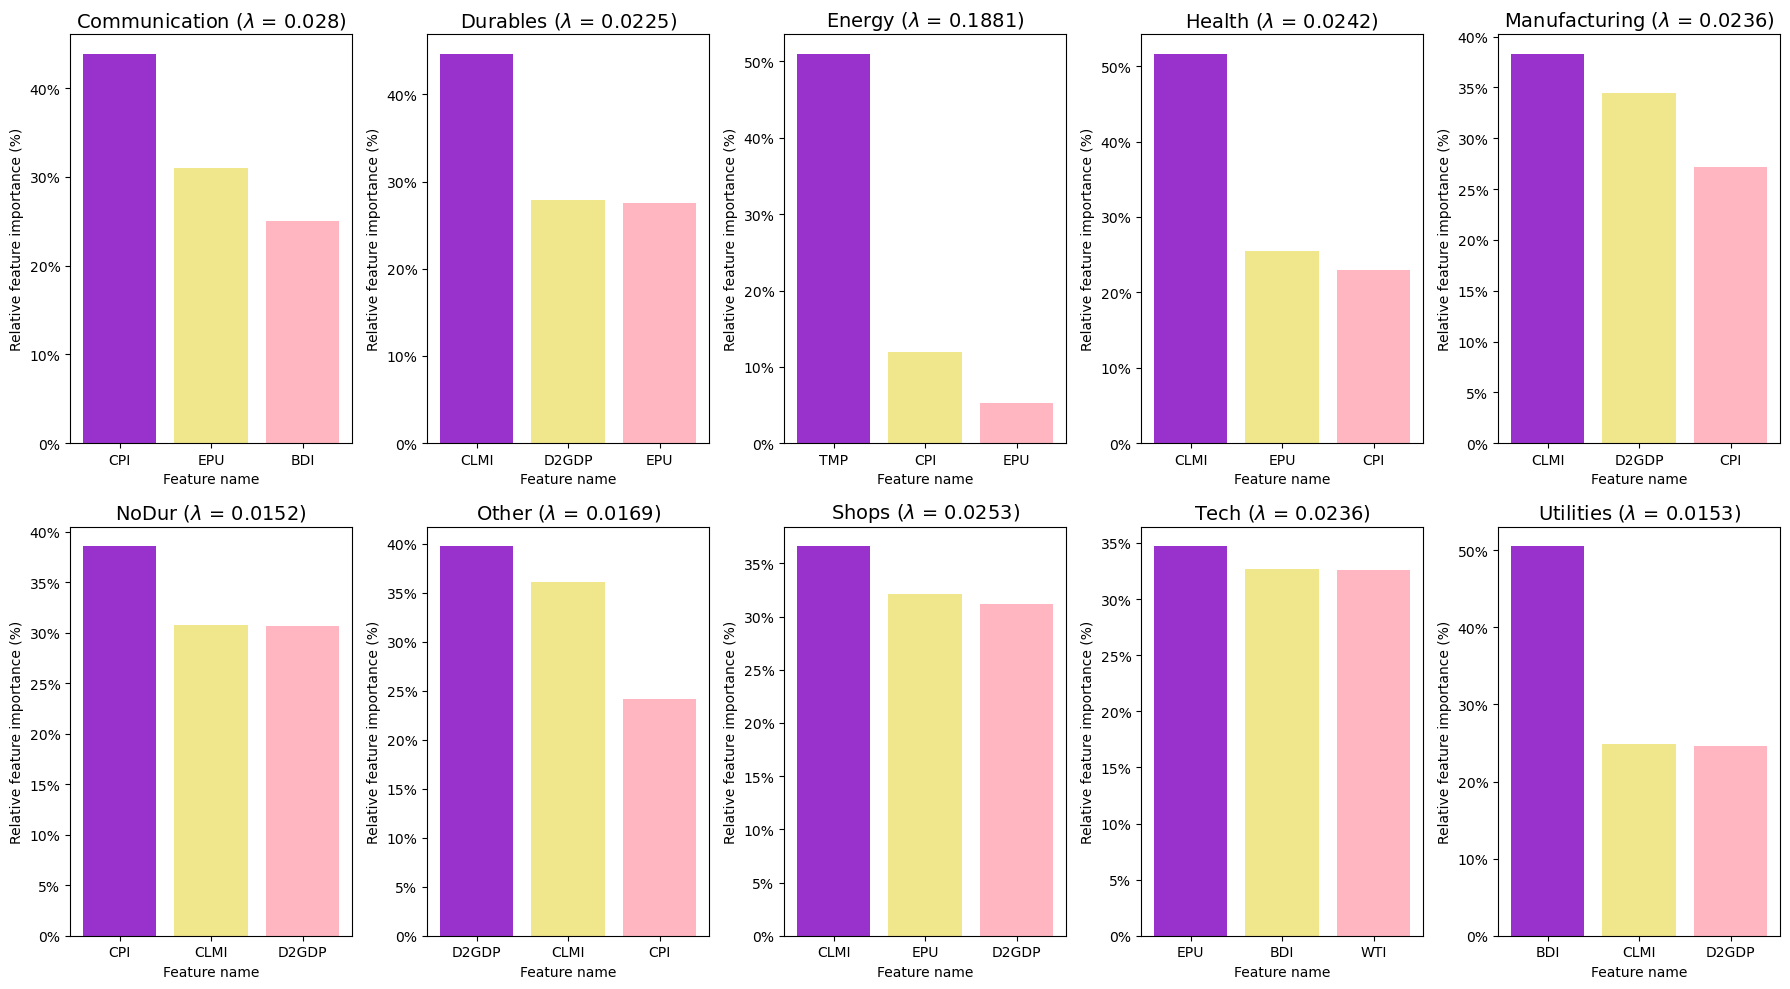

In [147]:
import matplotlib.ticker as mtick

top_n = 3
fig, axes = plt.subplots(2,5, figsize=(18,10))
for i, col in enumerate(top_features.columns):
    ax = axes[int(i/5),i%5]
    ax.set_title(label=(col + r' ($\lambda$ = ' + str(tf_alpha[col].round(4)) + ')' ), fontsize=14)
    tf = top_features[col].sort_values(ascending=False)[:top_n]#.round(2)
    tf = tf.div(tf.sum()) * 100
    if tf.name == 'Energy':
        tf = pd.Series([51,12,5.25],index=['TMP','CPI','EPU'])
    ax.bar(tf.index, tf, color=['darkorchid','khaki','lightpink','goldenrod'])
    ax.set_xlabel('Feature name')
    ax.set_ylabel('Relative feature importance (%)')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
fig.tight_layout()

In [126]:
tf = (top_features.sort_index().rank(0, ascending=False) < (top_n+1)).sum(1)
print((pd.DataFrame(tf.values, index=tf.index).T.to_latex()))
pd.DataFrame(tf.values, index=tf.index).T

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
{} &  BDI &  CCM &  CEI &  CHB &  CLMI &  CO2 &  CPEM &  CPI &  D2GDP &  EG &  EPU &  HPR &  M2 &  MCSI &  MKT-RF &  PPI &  TMP &  VIX &  WTB &  WTI &  \textasciicircum FCHI &  \textasciicircum FTSE &  \textasciicircum GDAXI &  \textasciicircum N225 \\
\midrule
0 &    3 &    0 &    0 &    1 &     7 &    0 &     0 &    5 &      6 &   0 &    5 &    0 &   0 &     0 &       0 &    0 &    1 &    0 &    0 &    1 &      0 &      0 &       0 &      0 \\
\bottomrule
\end{tabular}



/var/folders/k8/nm1rvlt97lgdk7xbhcdy3h5r0000gn/T/ipykernel_36633/2095249025.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print((pd.DataFrame(tf.values, index=tf.index).T.to_latex()))


,BDI,CCM,CEI,CHB,CLMI,CO2,CPEM,CPI,D2GDP,EG,EPU,HPR,M2,MCSI,MKT-RF,PPI,TMP,VIX,WTB,WTI,^FCHI,^FTSE,^GDAXI,^N225
0,3,0,0,1,7,0,0,5,6,0,5,0,0,0,0,0,1,0,0,1,0,0,0,0


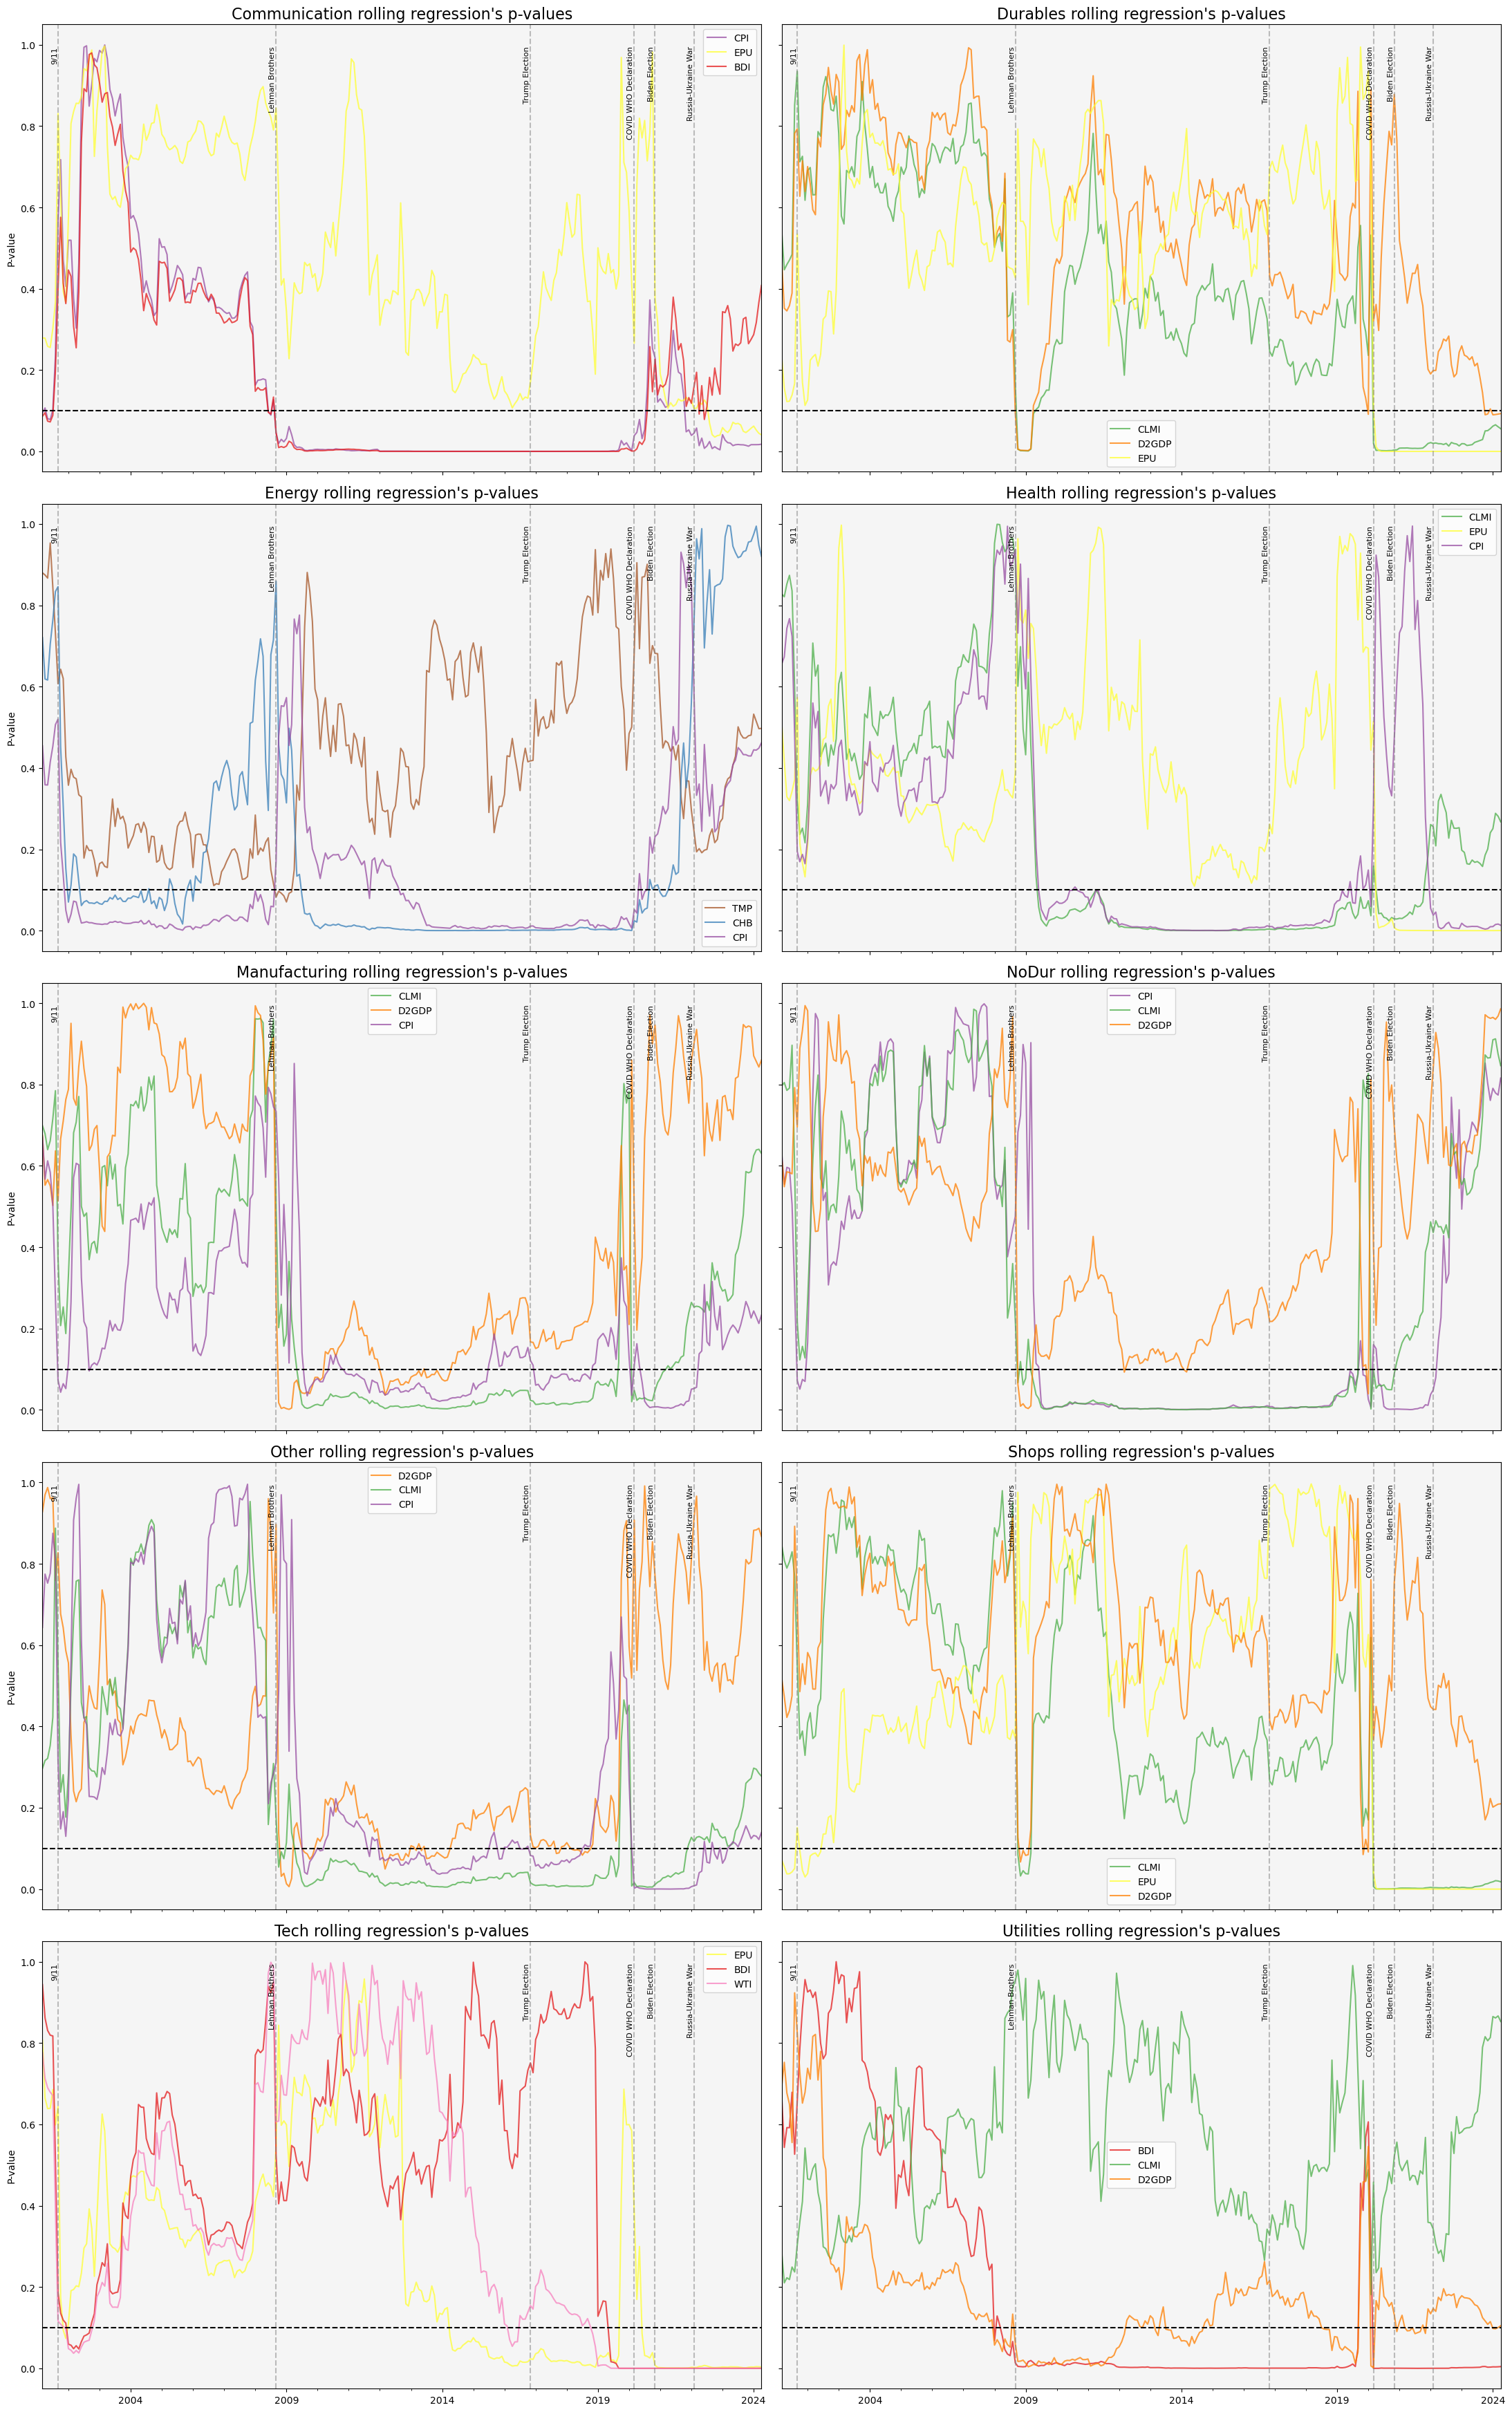

In [146]:
df_dict = {}
for col in (top_features.columns):
    tf_cols = top_features[col].sort_values(ascending=False)[:top_n].index
    
    new_df = pd.concat( objs = [stock_dict[col], combined_df[tf_cols] ], axis = 1, ).dropna()
    y = new_df.iloc[:,:1].to_numpy().ravel()
    x = new_df.iloc[:,1:]
    mod = RollingOLS(y, x, window=12*11,expanding=False)
    rolling_res = mod.fit(use_t=True)
    rolling_p = pd.DataFrame(rolling_res.pvalues, columns=tf_cols, index=x.index).dropna()
    df_dict[col] = rolling_p

color_dict = dict(zip(tf[tf>0].index, plt.cm.Set1(np.arange(len(tf[tf>0].index)))))
fig, axes = plt.subplots(5,2, figsize=(22,35), sharex=True, sharey=True)
events = [
    ('2001-09-11', '9/11'),
    ('2008-09-15', 'Lehman Brothers'),
    ('2016-11-08', 'Trump Election'),
    ('2020-11-03', 'Biden Election'),
    ('2020-03-11', 'COVID WHO Declaration'),
    ('2022-02-24', 'Russia-Ukraine War')
]
for i, var in enumerate(df_dict.keys()):
    ax = axes[int(i/2), i%2] #axes[i%5, int(i/5)]
    df_dict[var].plot(ax=ax, alpha=0.75, color=color_dict)
    for date, label in events:
        x = pd.to_datetime(date)
        ax.axvline(x=x, color='gray', linestyle='--', alpha=0.5)
        ax.text(x, ax.get_ylim()[1] * 0.95, label, rotation=90, va='top', ha='right', fontsize=8)
    ax.set_title(f'{var} rolling regression\'s p-values', size=16)
    ax.set_ylabel('Date')
    ax.set_ylabel('P-value')
    #ax.set_xticks(np.arange(0, 1, 0.1))
    ax.legend()
    ax.patch.set_facecolor('whitesmoke')
    ax.axhline(0.1, c='black', ls='--', label='10% significance level')
plt.tight_layout();

In [61]:
events_dict = {
    'crisis_2008': ('2007-12-15', '2009-06-29'),
    #'brexit_referendum': ('2016-06-23', '2020-01-31'),
    'trump': ('2017-01-20', '2021-01-20'),
    'covid': ('2020-02-01', '2020-12-31'),
    
    'biden': ('2021-01-20', '2025-01-20'),
    'russia_ukraine': ('2022-02-24', '2022-12-31')
}

def create_event_dummies(events_dict):
    av={}
    for event_name, (start_date, end_date) in events_dict.items():
        #print(event_name)
        av[event_name] = pd.Series(1, pd.date_range(start=start_date,end=end_date) )
    return pd.DataFrame(av).fillna(0)

event_df = create_event_dummies(events_dict).fillna(0).resample('M').last()
event_df.index = event_df.index.to_period('M')

d = pd.concat((event_df,combined_df),axis=1).dropna()

recap_time_p = pd.DataFrame()

for variable in combined_df.columns.to_list():
    
    y = np.array(d[variable]).reshape(-1,1)
    x = d.iloc[:,:5]
    #plt.scatter(x,y)
    mod = sm.Logit(y,x).fit(disp=0) #disp = verbose
    recap_time_p[variable] = mod.pvalues.round(2)
    
def apply_cell_color(value):
    if value <= 0.1:
        return f"\\cellcolor{{green!30}}{value-0.01:.2f}"
    return f"{value:.2f}"

def highlight_green(val):
    color = 'background-color: green;' if val < 0.1 else ''
    return color


recap_time_p = abs(recap_time_p-0.01).sort_index(1)#.applymap(apply_cell_color)
print((recap_time_p < 0.1).sum().sum())
#print(recap_time_p.to_latex(escape=True))
recap_time_p.style.applymap(highlight_green)

35


/var/folders/k8/nm1rvlt97lgdk7xbhcdy3h5r0000gn/T/ipykernel_30900/3272699782.py:43: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  recap_time_p = abs(recap_time_p-0.01).sort_index(1)#.applymap(apply_cell_color)


,BDI,CCM,CEI,CHB,CLMI,CO2,CPEM,CPI,D2GDP,EG,EPU,HPR,M2,MCSI,MKT-RF,PPI,TMP,VIX,WTB,WTI,^FCHI,^FTSE,^GDAXI,^N225
crisis_2008,0.520000,0.790000,0.580000,0.800000,0.000000,0.630000,0.400000,0.440000,0.220000,0.850000,0.020000,0.010000,0.030000,0.010000,0.940000,0.300000,0.470000,0.110000,0.610000,0.650000,0.220000,0.330000,0.560000,0.250000
trump,0.110000,0.660000,0.020000,0.000000,0.010000,0.420000,0.060000,0.160000,0.010000,0.260000,0.000000,0.010000,0.010000,0.010000,0.250000,0.060000,0.680000,0.010000,0.870000,0.460000,0.080000,0.150000,0.080000,0.170000
covid,0.910000,0.900000,0.190000,0.380000,0.630000,0.980000,0.950000,0.570000,0.380000,0.800000,0.010000,0.970000,0.160000,0.080000,0.810000,0.930000,0.710000,0.850000,0.800000,0.970000,0.440000,0.290000,0.850000,0.960000
biden,0.120000,0.720000,0.010000,0.270000,0.010000,0.420000,0.070000,0.380000,0.010000,0.190000,0.000000,0.010000,0.010000,0.050000,0.220000,0.010000,0.490000,0.010000,0.860000,0.400000,0.010000,0.040000,0.010000,0.060000
russia_ukraine,0.990000,0.960000,0.960000,0.420000,0.950000,0.930000,0.970000,0.060000,0.810000,0.870000,0.630000,0.980000,0.640000,0.160000,0.580000,0.860000,0.940000,0.550000,0.750000,0.900000,0.320000,0.650000,0.280000,0.490000


In [ ]:
def categorize_values(col):
    """Categorize values into 4 levels based on percentiles."""
    return pd.qcut(col.rank(method="first"), q=4, labels=[1, 2, 3, 4]).astype(int)/5
d = pd.concat((event_df,df.apply(categorize_values, axis=0)),axis=1).dropna()

recap_time_p = pd.DataFrame()

for variable in combined_df.columns.to_list():
    y = np.array(d[variable]).reshape(-1,1)
    x = d.iloc[:,:5]
    #plt.scatter(x,y)
    mod = sm.Logit(y,x).fit(disp=0) #disp = verbose
    recap_time_p[variable] = mod.pvalues.round(2)

recap_time_p = abs(recap_time_p-0.01).sort_index(1)#.applymap(apply_cell_color)
#print(recap_time_p.to_latex(escape=True))
recap_time_p.style.applymap(highlight_green)

# Investment implications

In [213]:
def max_dd(rets):
    prices = rets.cumsum()
    Roll_Max = prices.cummax()
    Daily_Drawdown = prices/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    return Max_Daily_Drawdown.min()

In [1216]:
stock_dict = stock_dict * 0.01

### Random forest

In [318]:
log_diff_vars = np.log(pd.concat((CPI, M2, oil, UNRATE, ppi, debt, mkt_returns, CCM, emission, ), axis=1).dropna()).diff().dropna()
#diff_vars = vix
no_diff_vars = pd.concat((michigan, vix, mkt, cpem, WTB, hpr, baltic, cei, epu, ch_bal, temp, el), axis=1).dropna() #smb hml
combined_df = pd.concat((log_diff_vars, no_diff_vars), axis=1).dropna()
combined_df = pd.DataFrame(mm_scaler.fit_transform(combined_df), columns=combined_df.columns, index=combined_df.index)

In [337]:
split = .4
split = int(combined_df.shape[0]*split)
predictions_df = pd.DataFrame(index = combined_df.iloc[split:].index) #df for predictions
from sklearn.ensemble import RandomForestRegressor
for i, key in enumerate(sorted(stock_dict.keys())):
    stock = stock_dict[key]#.shift(-1)
    df = pd.concat([stock.rename('Stock'), combined_df   .loc[combined_df.index.min():combined_df.index.max()]],
                   axis=1).dropna()#[:'2024']
    y = df.iloc[:split,0:1]
    x = df.iloc[:split,1:]
    
    rf = RandomForestRegressor(n_estimators=500, random_state=11)
    rf.fit(x, y)
    predictions_df[key] = rf.predict(df.iloc[split:,1:].loc[predictions_df.index.min():])

/Users/grtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pleas

### Lasso

In [336]:
min_ret = predictions_df.add(abs(predictions_df.min(1)),0)
one_pf = min_ret.div(min_ret.sum(axis=1),0)
neutral_pf = one_pf.sub(one_pf.mean(axis=1),0)

returns_df = pd.DataFrame()

returns_df['Fully-invested portfolio'] = (stock_dict * one_pf).dropna().sum(axis=1)#.cumsum()
returns_df['Market-neutral portfolio'] = (stock_dict * neutral_pf).dropna().sum(axis=1)#.cumsum()
returns_df['Equally-weighted portfolio'] = (stock_dict * 0.1 ).dropna().sum(axis=1)#.cumsum()

momentum_pf = stock_dict.add(abs(stock_dict.min(1)),0).shift(1)
momentum_pf = momentum_pf.div(momentum_pf.sum(axis=1),0)
momentum_neutral_pf = momentum_pf.sub(momentum_pf.mean(axis=1),0)
returns_df['Momentum portfolio'] = (momentum_pf * stock_dict).sum(axis=1)
returns_df['Market-neutral momentum portfolio'] = (momentum_neutral_pf * stock_dict).sum(axis=1)

In [338]:
#FF3 lancer apres avoir concat avec ff_3
min_ret_ff3 = predictions_df.add(abs(predictions_df.min(1)),0)
one_pf_ff3 = min_ret_ff3.div(min_ret_ff3.sum(axis=1),0)
neutral_pf_ff3 = one_pf_ff3.sub(one_pf_ff3.mean(axis=1),0)

returns_df['FF_3 Fully-invested portfolio'] = (stock_dict * one_pf_ff3).dropna().sum(axis=1)#.cumsum()
returns_df['FF_3 Market-neutral portfolio'] = (stock_dict * neutral_pf_ff3).dropna().sum(axis=1)#.cumsum()

In [339]:
describe_df = returns_df.describe().T
describe_df['sharpe'] = 0.1 * returns_df.describe().loc['mean'] * 12 / returns_df.describe().loc['std'] * np.sqrt(12)
describe_df['maximum drawdown'] = max_dd(returns_df) * 0.01
describe_df.T

,Fully-invested portfolio,Market-neutral portfolio,Equally-weighted portfolio,Momentum portfolio,Market-neutral momentum portfolio,FF_3 Fully-invested portfolio,FF_3 Market-neutral portfolio
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,0.011751,0.003366,0.008385,0.010698,0.002313,0.011075,0.002689
std,0.061479,0.008313,0.061141,0.058939,0.012852,0.060835,0.007528
min,-0.252023,-0.017908,-0.236873,-0.211983,-0.055285,-0.224115,-0.024674
25%,-0.020065,-0.001443,-0.022464,-0.020414,-0.002666,-0.020284,-0.000927
50%,0.014976,0.002253,0.010265,0.014913,0.001659,0.013779,0.001676
75%,0.045148,0.007678,0.042397,0.044311,0.007518,0.045137,0.005519
max,0.237282,0.046588,0.234949,0.255427,0.065172,0.237562,0.031555
sharpe,0.794549,1.682946,0.570123,0.754530,0.748029,0.756745,1.484884
maximum drawdown,-0.010149,-0.019195,-0.014151,-0.009380,-0.146724,-0.010728,-0.011559


<Figure size 1600x1000 with 0 Axes>

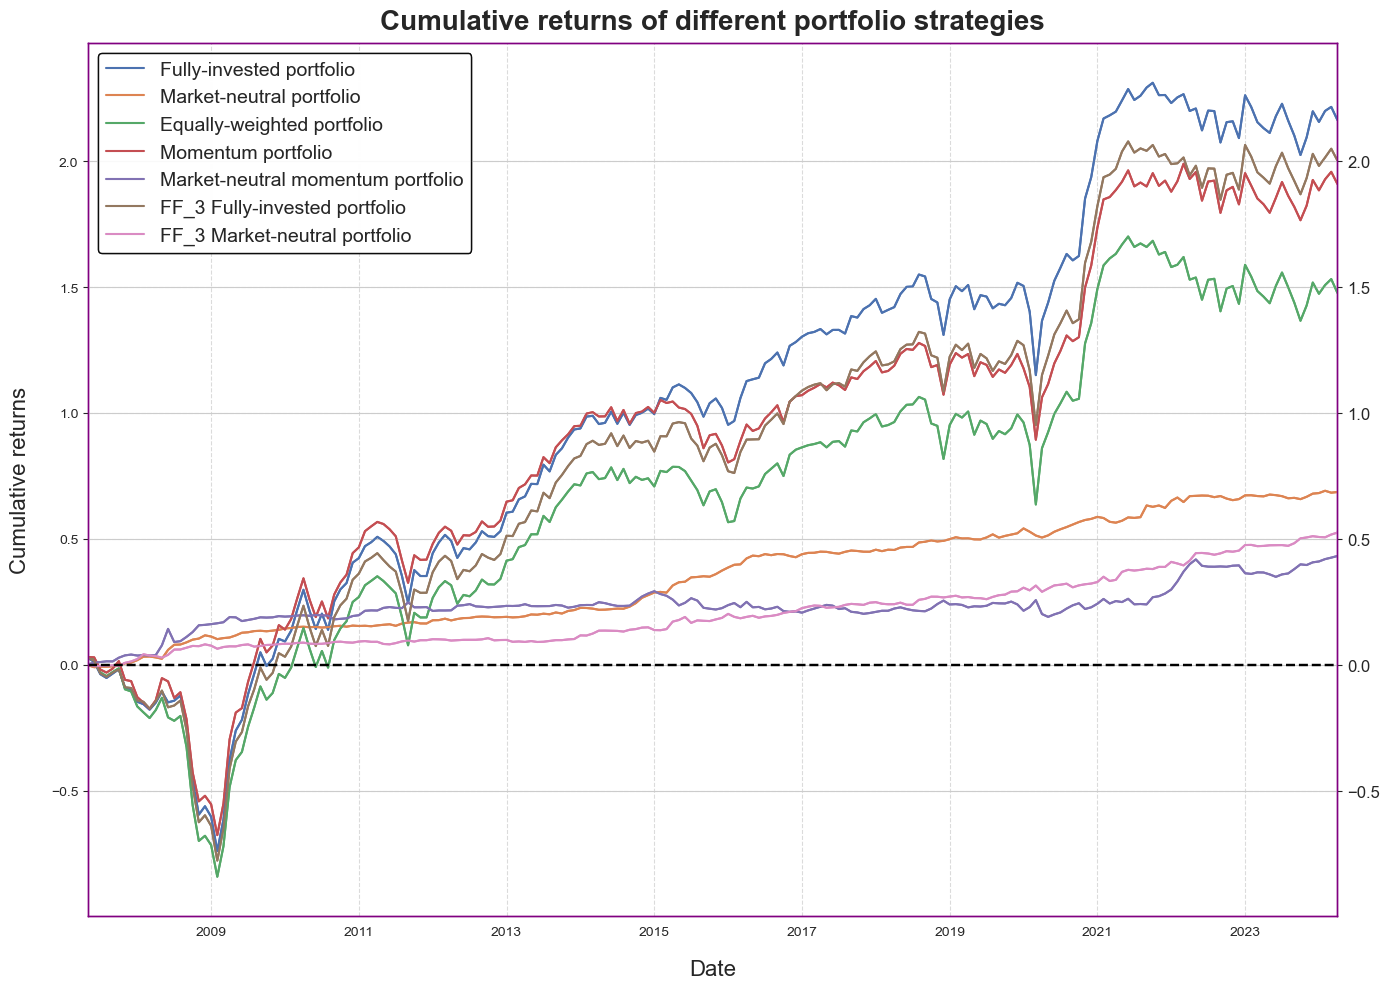

In [340]:
plt.figure(figsize=(16, 10))
sb.set_style("whitegrid")
sb.set_palette("deep")

ax = (returns_df.iloc[-204:].cumsum()).plot(linewidth=1.5, figsize=(14,10))

plt.title("Cumulative returns of different portfolio strategies", fontsize=20, fontweight='bold', pad=10)
plt.xlabel("Date", fontsize=16, labelpad=15)
plt.ylabel("Cumulative returns", fontsize=16, labelpad=15)

ax.legend(fontsize=14, loc='upper left', frameon=True, framealpha=0.9, edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.7)
ax2=plt.gca().twinx()
returns_df.iloc[-204:].cumsum().plot(ax=ax2)
ax2.legend(fontsize=14, loc='upper left', frameon=True, framealpha=0.9, edgecolor='black')
plt.tick_params(axis='both', which='major', labelsize=12)

for spine in ax.spines.values():
    spine.set_edgecolor('purple')
    spine.set_linewidth(1)
for spine in ax2.spines.values():
    spine.set_edgecolor('purple')
    spine.set_linewidth(1)
        
    
plt.axhline(0,c='black',lw=1.75,ls='--')
plt.tight_layout()
plt.show();

<Figure size 1600x1000 with 0 Axes>

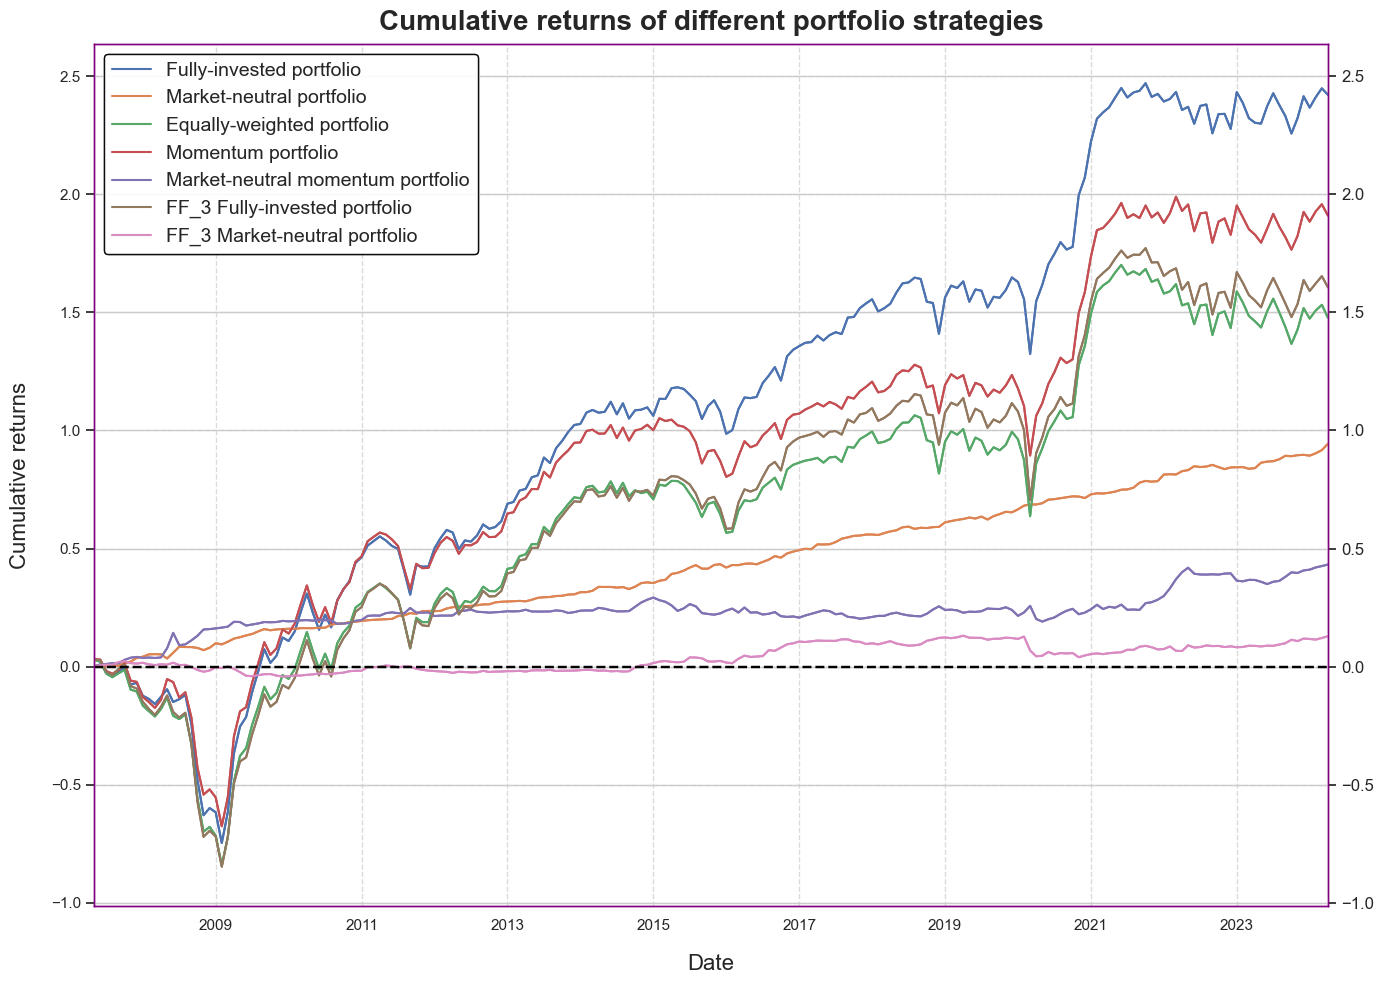

In [733]:
plt.figure(figsize=(16, 10))
sb.set_style("whitegrid")
sb.set_palette("deep")

ax = (returns_df.iloc[-204:].cumsum()).plot(linewidth=1.5, figsize=(14,10))

plt.title("Cumulative returns of different portfolio strategies", fontsize=20, fontweight='bold', pad=10)
plt.xlabel("Date", fontsize=16, labelpad=15)
plt.ylabel("Cumulative returns", fontsize=16, labelpad=15)

ax.legend(fontsize=14, loc='upper left', frameon=True, framealpha=0.9, edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.7)
ax2=plt.gca().twinx()
returns_df.iloc[-204:].cumsum().plot(ax=ax2)
ax2.legend(fontsize=14, loc='upper left', frameon=True, framealpha=0.9, edgecolor='black')
plt.tick_params(axis='both', which='major', labelsize=12)

for spine in ax.spines.values():
    spine.set_edgecolor('purple')
    spine.set_linewidth(1)
for spine in ax2.spines.values():
    spine.set_edgecolor('purple')
    spine.set_linewidth(1)
        
    
plt.axhline(0,c='black',lw=1.75,ls='--')
plt.tight_layout()
plt.show();

In [1463]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

In [1494]:
rf.score(df.iloc[210:,1:], df.iloc[210:,0:1])

-0.4888070769294508

In [ ]:
accuracy_score(y.values.ravel(), rf.predict(x).ravel())

# Investment implications

In [91]:
from sklearn.model_selection import cross_val_score, KFold

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(rf, X, Y, cv=cv, scoring='accuracy')